In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from density_engine.skew_student_t import HansenSkewedT_torch


# Checking mean=0 and std=1

The mean should be zero, and the std 1.

In [2]:

cases = [
    {'eta': 20.0, 'lam': 0.0},
    {'eta': 10.0, 'lam': 0.0},
    {'eta': 10.0, 'lam': 0.5},
    {'eta': 10.0, 'lam': -0.5},
]

In [3]:
# Empirically validate mean=0 and std=1
for case in cases:
    eng = HansenSkewedT_torch(eta=case['eta'], lam=case['lam'])
    
    # Analytical values (should be 0 and 1 for standardized distribution)
    analytical_mean = 0.0
    analytical_std = 1.0
    
    # Empirical validation via sampling
    mean_values = []
    std_values = []
    for i in range(5):
        samples = eng.rvs(1_000_000)
        mean_values.append(torch.mean(samples).item())
        std_values.append(torch.std(samples).item())
    
    empirical_mean = np.mean(mean_values)
    empirical_mean_std = np.std(mean_values)
    empirical_std = np.mean(std_values)
    empirical_std_std = np.std(std_values)
    
    print(f'eta = {case["eta"]:.2f}, lam = {case["lam"]:.2f}')
    print(f'  Mean - Analytical: {analytical_mean:.6f}')
    print(f'  Mean - Empirical:  {empirical_mean:.6f} ± {empirical_mean_std:.6f}')
    print(f'  Mean - Difference: {abs(analytical_mean - empirical_mean):.6f}')
    print(f'  Std  - Analytical: {analytical_std:.6f}')
    print(f'  Std  - Empirical:  {empirical_std:.6f} ± {empirical_std_std:.6f}')
    print(f'  Std  - Difference: {abs(analytical_std - empirical_std):.6f}')
    print()



eta = 20.00, lam = 0.00
  Mean - Analytical: 0.000000
  Mean - Empirical:  -0.000258 ± 0.000395
  Mean - Difference: 0.000258
  Std  - Analytical: 1.000000
  Std  - Empirical:  1.000295 ± 0.000621
  Std  - Difference: 0.000295

eta = 10.00, lam = 0.00
  Mean - Analytical: 0.000000
  Mean - Empirical:  0.000294 ± 0.001096
  Mean - Difference: 0.000294
  Std  - Analytical: 1.000000
  Std  - Empirical:  1.000307 ± 0.000775
  Std  - Difference: 0.000307

eta = 10.00, lam = 0.50
  Mean - Analytical: 0.000000
  Mean - Empirical:  0.000391 ± 0.000473
  Mean - Difference: 0.000391
  Std  - Analytical: 1.000000
  Std  - Empirical:  1.000354 ± 0.000816
  Std  - Difference: 0.000354

eta = 10.00, lam = -0.50
  Mean - Analytical: 0.000000
  Mean - Empirical:  -0.000161 ± 0.000606
  Mean - Difference: 0.000161
  Std  - Analytical: 1.000000
  Std  - Empirical:  1.000248 ± 0.001021
  Std  - Difference: 0.000248



# Checking samples vs pdf

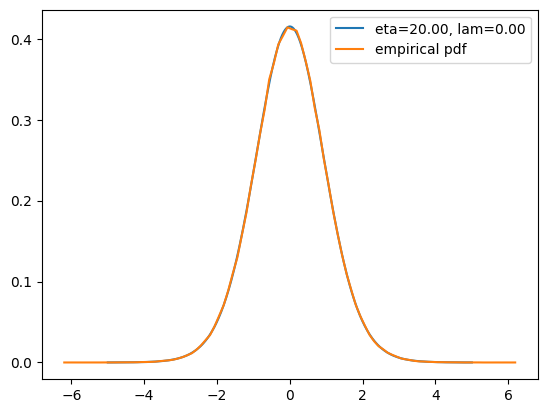

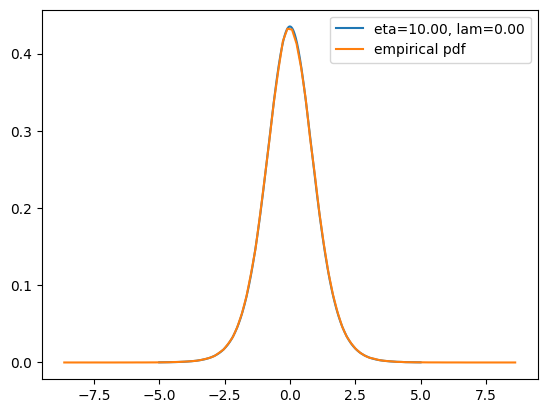

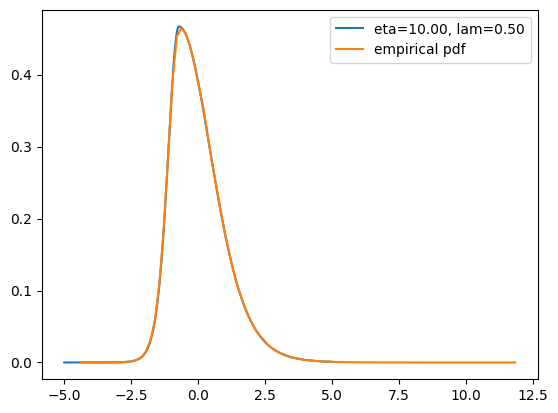

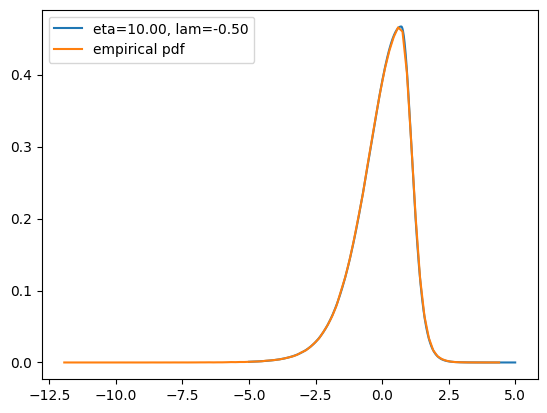

In [4]:
for case in cases:
    eng = HansenSkewedT_torch(eta=case['eta'], lam=case['lam'])

    x = np.linspace(-5, 5, 1000)
    pdf_values = eng.pdf(x).cpu().numpy()

    # compute empirical pdf
    samples = eng.rvs(1_000_000)
    hist, bin_edges = np.histogram(samples.cpu().numpy(), bins=100, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.plot(x, pdf_values, label=f'eta={case["eta"]:.2f}, lam={case["lam"]:.2f}')
    plt.plot(bin_centers, hist, label='empirical pdf')
    plt.legend()
    plt.show()


# Checking samples vs cdf

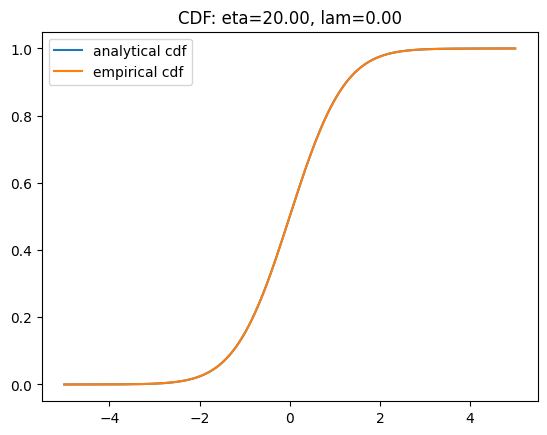

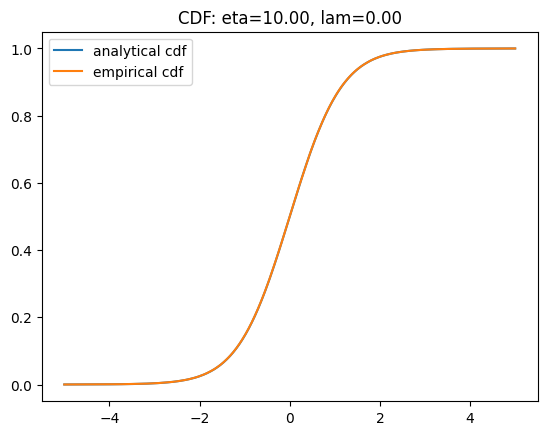

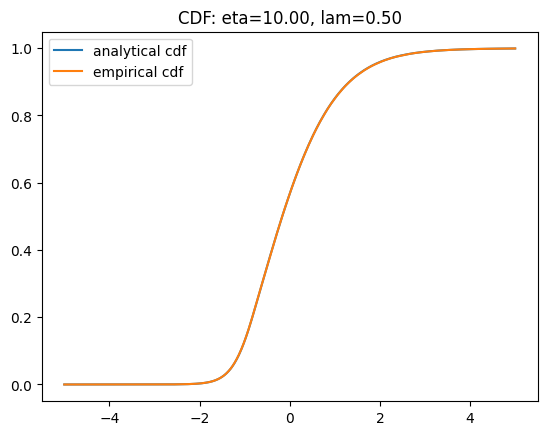

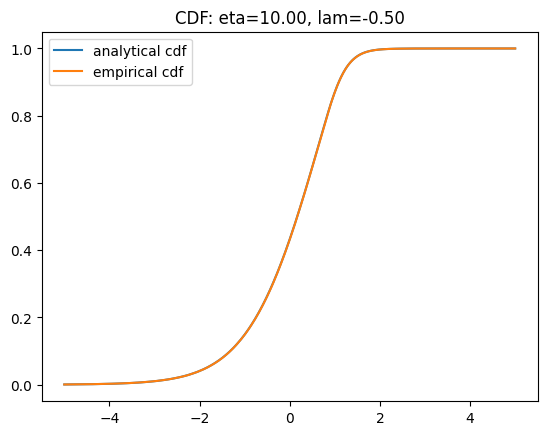

In [5]:
# Compare CDF: samples vs analytical
for case in cases:
    eng = HansenSkewedT_torch(eta=case['eta'], lam=case['lam'])

    x = np.linspace(-5, 5, 1000)
    cdf_values = eng.cdf(x).cpu().numpy()

    samples = eng.rvs(1_000_000).cpu().numpy()
    # compute the mpirical cdf for the x values
    cdf_values_emp = np.mean(samples < x[:, np.newaxis], axis=1)    


    plt.plot(x, cdf_values, label=f'analytical cdf')
    plt.plot(x, cdf_values_emp, label='empirical cdf')
    plt.title(f'CDF: eta={case["eta"]:.2f}, lam={case["lam"]:.2f}') 
    plt.legend()
    plt.show()



# Checking second moment left

The `second_moment_left` function computes E[ε²𝟙{ε<0}] = ∫₋∞⁰ x²f(x)dx. We can validate this empirically by computing the sample mean of x² for negative samples.


# Checking CDF vs numerical integration of PDF

We can validate the CDF by comparing it with numerical integration of the PDF:
F(x) = ∫₋∞ˣ f(t)dt

This ensures consistency between the PDF and CDF implementations.


In [6]:
# Validate CDF against numerical integration of PDF
from scipy.integrate import quad

for case in cases:
    eng = HansenSkewedT_torch(eta=case['eta'], lam=case['lam'])
    
    # Test points for CDF evaluation
    test_points = np.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
    
    print(f'eta = {case["eta"]:.2f}, lam = {case["lam"]:.2f}')
    
    # Analytical CDF values
    cdf_analytical = eng.cdf(test_points).cpu().numpy()
    
    # Numerical integration of PDF
    cdf_numerical = []
    for x in test_points:
        # Define integrand function for this specific case
        def integrand(t):
            # Convert to numpy for scipy integration
            t_np = np.asarray(t)
            pdf_values = eng.pdf(t_np).cpu().numpy()
            return pdf_values
        
        # Integrate from -infinity to x
        integral, _ = quad(integrand, -np.inf, x, epsabs=1e-10, epsrel=1e-8, limit=200)
        cdf_numerical.append(integral)
    
    cdf_numerical = np.array(cdf_numerical)
    
    # Compare results
    differences = np.abs(cdf_analytical - cdf_numerical)
    max_diff = np.max(differences)
    mean_diff = np.mean(differences)
    
    print(f'  Test points: {test_points}')
    print(f'  CDF Analytical: {cdf_analytical}')
    print(f'  CDF Numerical:  {cdf_numerical}')
    print(f'  Differences:     {differences}')
    print(f'  Max difference: {max_diff:.8f}')
    print(f'  Mean difference: {mean_diff:.8f}')
    print()


eta = 20.00, lam = 0.00


/var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/ipykernel_94844/595963268.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(integrand, -np.inf, x, epsabs=1e-10, epsrel=1e-8, limit=200)


  Test points: [-3. -2. -1.  0.  1.  2.  3.]
  CDF Analytical: [0.00244999 0.02391375 0.15220456 0.5        0.8477954  0.97608626
 0.99755   ]
  CDF Numerical:  [0.00244999 0.02391375 0.15220459 0.50000009 0.8477956  0.97608644
 0.9975502 ]
  Differences:     [1.31042126e-09 3.80721691e-09 2.72345144e-08 9.05677873e-08
 1.72294263e-07 1.77282451e-07 1.85892073e-07]
  Max difference: 0.00000019
  Mean difference: 0.00000009

eta = 10.00, lam = 0.00
  Test points: [-3. -2. -1.  0.  1.  2.  3.]
  CDF Analytical: [0.00365731 0.0246661  0.1448458  0.5        0.8551542  0.9753339
 0.9963427 ]
  CDF Numerical:  [0.00365731 0.0246661  0.14484582 0.50000003 0.85515424 0.97533395
 0.99634275]
  Differences:     [1.17457918e-09 5.65926942e-09 2.06417559e-08 2.95794688e-08
 2.10215154e-08 2.23638090e-08 2.99620748e-08]
  Max difference: 0.00000003
  Mean difference: 0.00000002

eta = 10.00, lam = 0.50
  Test points: [-3. -2. -1.  0.  1.  2.  3.]
  CDF Analytical: [6.8247035e-05 2.9585487e-03 1.294

In [7]:
# Compact CDF vs PDF integration validation (same format as other tests)
for case in cases:
    eng = HansenSkewedT_torch(eta=case['eta'], lam=case['lam'])
    
    # Test points for CDF evaluation
    test_points = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
    
    # Analytical CDF values
    cdf_analytical = eng.cdf(test_points).cpu().numpy()
    
    # Numerical integration of PDF
    cdf_numerical = []
    for x in test_points:
        def integrand(t):
            t_np = np.asarray(t)
            pdf_values = eng.pdf(t_np).cpu().numpy()
            return pdf_values
        
        integral, _ = quad(integrand, -np.inf, x, epsabs=1e-10, epsrel=1e-8, limit=200)
        cdf_numerical.append(integral)
    
    cdf_numerical = np.array(cdf_numerical)
    
    # Compare results
    differences = np.abs(cdf_analytical - cdf_numerical)
    max_diff = np.max(differences)
    mean_diff = np.mean(differences)
    
    print(f'eta = {case["eta"]:.2f}, lam = {case["lam"]:.2f}')
    print(f'  CDF vs Integration - Max difference: {max_diff:.8f}')
    print(f'  CDF vs Integration - Mean difference: {mean_diff:.8f}')
    print()


/var/folders/5g/0dhhbmg52yd5rkn3lr8br8mh0000gn/T/ipykernel_94844/2575857701.py:19: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(integrand, -np.inf, x, epsabs=1e-10, epsrel=1e-8, limit=200)


eta = 20.00, lam = 0.00
  CDF vs Integration - Max difference: 0.00000018
  CDF vs Integration - Mean difference: 0.00000009

eta = 10.00, lam = 0.00
  CDF vs Integration - Max difference: 0.00000003
  CDF vs Integration - Mean difference: 0.00000002

eta = 10.00, lam = 0.50
  CDF vs Integration - Max difference: 0.00000007
  CDF vs Integration - Mean difference: 0.00000003

eta = 10.00, lam = -0.50
  CDF vs Integration - Max difference: 0.00000007
  CDF vs Integration - Mean difference: 0.00000003



In [8]:
# Empirically validate second_moment_left function
for case in cases:
    eng = HansenSkewedT_torch(eta=case['eta'], lam=case['lam'])
    
    # Analytical value
    analytical = eng.second_moment_left().item()
    
    # Empirical validation via sampling
    empirical_values = []
    for i in range(5):
        samples = eng.rvs(1_000_000)
        # Compute E[x²𝟙{x<0}] empirically using indicator function
        indicator_values = torch.where(samples < 0, samples**2, torch.zeros_like(samples))
        empirical = torch.mean(indicator_values).item()
        empirical_values.append(empirical)
    
    empirical_mean = np.mean(empirical_values)
    empirical_std = np.std(empirical_values)
    
    print(f'eta = {case["eta"]:.2f}, lam = {case["lam"]:.2f}')
    print(f'  Analytical: {analytical:.6f}')
    print(f'  Empirical:  {empirical_mean:.6f} ± {empirical_std:.6f}')
    print(f'  Difference: {abs(analytical - empirical_mean):.6f}')
    print()


eta = 20.00, lam = 0.00
  Analytical: 0.500000
  Empirical:  0.500440 ± 0.001020
  Difference: 0.000440

eta = 10.00, lam = 0.00
  Analytical: 0.500000
  Empirical:  0.501063 ± 0.000987
  Difference: 0.001063

eta = 10.00, lam = 0.50
  Analytical: 0.371111
  Empirical:  0.371620 ± 0.000743
  Difference: 0.000509

eta = 10.00, lam = -0.50
  Analytical: 0.628889
  Empirical:  0.629955 ± 0.001694
  Difference: 0.001066

